In [1]:
!pip install -q gdown

In [2]:
!gdown 1ySgHW7i2B1WRZPLucVgOFRvU5O5D0O00 -O /kaggle/working/resnet_50.pt

Downloading...
From (original): https://drive.google.com/uc?id=1ySgHW7i2B1WRZPLucVgOFRvU5O5D0O00
From (redirected): https://drive.google.com/uc?id=1ySgHW7i2B1WRZPLucVgOFRvU5O5D0O00&confirm=t&uuid=3cd2421d-e8ed-4999-acbd-d2ec8b308604
To: /kaggle/working/resnet_50.pt
100%|████████████████████████████████████████| 283M/283M [00:02<00:00, 97.6MB/s]


In [3]:
!gdown 18HPlcaoytmjc7NXgZeQPURfiZkzQFl32 -O /kaggle/working/efficientnet_b0.pt

Downloading...
From: https://drive.google.com/uc?id=18HPlcaoytmjc7NXgZeQPURfiZkzQFl32
To: /kaggle/working/efficientnet_b0.pt
100%|██████████████████████████████████████| 16.4M/16.4M [00:00<00:00, 60.0MB/s]


In [4]:
!gdown 1f8yGxcimwi7nYzRCHiVwqqGNwKUzSipM -O /kaggle/working/vgg_16.pt

Downloading...
From (original): https://drive.google.com/uc?id=1f8yGxcimwi7nYzRCHiVwqqGNwKUzSipM
From (redirected): https://drive.google.com/uc?id=1f8yGxcimwi7nYzRCHiVwqqGNwKUzSipM&confirm=t&uuid=a689ac06-fa6f-49f0-9dad-f069b4be914b
To: /kaggle/working/vgg_16.pt
100%|████████████████████████████████████████| 164M/164M [00:01<00:00, 99.4MB/s]


In [5]:
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Subset
import torch
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset

# 1) Selected 5 Classes
selected_classes = [
    "Impressionism",
    "Realism",
    "Expressionism",
    "Romanticism",
    "Post_Impressionism"
]


# --- Enhanced Data Augmentation for Training ---
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224, scale=(0.5, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05),
    transforms.RandomRotation(5),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Standard Transform for Validation/Test ---
val_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# --- Load Dataset ---
dataset = datasets.ImageFolder("/kaggle/input/wikiart", transform=None)


# 4) Filter Dataset to Selected Classes Only
# =====================================================
class_to_idx = dataset.class_to_idx

selected_class_indices = [
    class_to_idx[c] for c in selected_classes if c in class_to_idx
]

filtered_indices = [
    i for i, (_, label) in enumerate(dataset.samples)
    if label in selected_class_indices
]

filtered_dataset = Subset(dataset, filtered_indices)

print(f"Filtered dataset size: {len(filtered_dataset)}")
print(f"Number of selected classes: {len(selected_class_indices)}")



all_indices = list(range(len(filtered_dataset)))

all_labels = [
    filtered_dataset.dataset.samples[idx][1]
    for idx in filtered_dataset.indices
]

# 6) Stratified Split (80 / 10 / 10)
# =====================================================
train_idx, temp_idx, train_labels, temp_labels = train_test_split(
    all_indices,
    all_labels,
    test_size=0.2,
    stratify=all_labels,
    random_state=42
)

val_idx, test_idx, _, _ = train_test_split(
    temp_idx,
    temp_labels,
    test_size=0.5,
    stratify=temp_labels,
    random_state=42
)

train_ds = Subset(filtered_dataset, train_idx)
val_ds   = Subset(filtered_dataset, val_idx)
test_ds  = Subset(filtered_dataset, test_idx)


# 6) Remap labels 0..14
old_to_new = {old_idx: new_idx for new_idx, old_idx in enumerate(selected_class_indices)}

class RemappedDataset(Dataset):
    def __init__(self, subset, old_to_new, transform=None):
        self.subset = subset
        self.old_to_new = old_to_new
        self.transform = transform

    def __len__(self):
        return len(self.subset)

    def __getitem__(self, idx):
        img, old_label = self.subset[idx]
        new_label = self.old_to_new[old_label]
        if self.transform:
            img = self.transform(img)

        return img, new_label



# Apply transforms
train_ds = RemappedDataset(train_ds, old_to_new, transform=train_transform)
val_ds   = RemappedDataset(val_ds, old_to_new, transform=val_test_transform)
test_ds  = RemappedDataset(test_ds, old_to_new, transform=val_test_transform)


BATCH_SIZE = 64  # Split across 2 GPUs (64 per GPU) - increase to 256 if memory allows

train_loader = DataLoader(
    train_ds,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,  # 2 workers per GPU
    pin_memory=True,  # Faster CPU-to-GPU transfer
    prefetch_factor=3,  # Prefetch 3 batches per worker
    persistent_workers=True  # Reuse workers between epochs
)

val_loader = DataLoader(
    val_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=3,
    persistent_workers=True
)

test_loader = DataLoader(
    test_ds,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True,
    prefetch_factor=3,
    persistent_workers=True
)

Filtered dataset size: 43998
Number of selected classes: 5


In [20]:


#--------------------resnet50--------------------



import torch
import torch.nn as nn
from torchvision import models
from collections import defaultdict
from tqdm import tqdm

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5


# ---- Model (MUST match training) ----
resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

resnet50.fc = nn.Sequential(
    nn.Dropout(0.5),
    nn.Linear(resnet50.fc.in_features, num_classes)
)

resnet50 = resnet50.to(device)

# ---- Load Checkpoint ----
checkpoint_path = "/kaggle/working/resnet_50.pt"
checkpoint = torch.load(checkpoint_path, map_location=device)

resnet50.load_state_dict(checkpoint["model_state_dict"])
resnet50.eval()

print("Model loaded EXACTLY as trained")

Model loaded EXACTLY as trained


In [19]:

#--------------------efficientnet_b0--------------------



import torch
import torch.nn as nn
from torchvision import models
from collections import defaultdict
from tqdm import tqdm

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5

# ---- Model (MUST match training) ----
efficientnet_b0 = models.efficientnet_b0(weights=models.EfficientNet_B0_Weights.IMAGENET1K_V1)
efficientnet_b0.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
efficientnet_b0 = efficientnet_b0.to(device)

# ---- Load Checkpoint ----
ckpt_path = "/kaggle/working/efficientnet_b0.pt"

efficientnet_b0.load_state_dict(torch.load(ckpt_path, map_location=device))

efficientnet_b0.eval()

print("Model loaded EXACTLY as trained")

Model loaded EXACTLY as trained


In [9]:


#--------------------vgg16--------------------



import torch
import torch.nn as nn
from torchvision import models
from collections import defaultdict
from tqdm import tqdm

# ---- Device ----
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

num_classes = 5

# ---- Model (MUST match training) ----
weights = models.VGG16_Weights.IMAGENET1K_V1
vgg16 = models.vgg16(weights=weights)

for p in vgg16.features.parameters():
    p.requires_grad = False

for p in vgg16.features[24:].parameters():
    p.requires_grad = True

vgg16.classifier = nn.Sequential(
    nn.Linear(25088,1024),
    nn.ReLU(True),
    nn.Dropout(0.4),
    nn.Linear(1024,512),
    nn.ReLU(True),
    nn.Dropout(0.4),
    nn.Linear(512,num_classes)
)
vgg16 = vgg16.to(device)

# ---- Load Checkpoint ----

best_model = "/kaggle/working/vgg_16.pt"

vgg16.load_state_dict(torch.load(best_model, map_location=device))
vgg16.eval()

print("Model loaded EXACTLY as trained")

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 210MB/s] 


Model loaded EXACTLY as trained


Overall Metrics
Accuracy : 0.6970
Precision: 0.6930
Recall   : 0.7032
F1-score : 0.6952

 Classification Report
              precision    recall  f1-score   support

           0     0.7751    0.6968    0.7339      1306
           1     0.7010    0.6403    0.6693      1073
           2     0.7174    0.7270    0.7222       674
           3     0.7441    0.7621    0.7530       702
           4     0.5273    0.6899    0.5977       645

    accuracy                         0.6970      4400
   macro avg     0.6930    0.7032    0.6952      4400
weighted avg     0.7069    0.6970    0.6994      4400



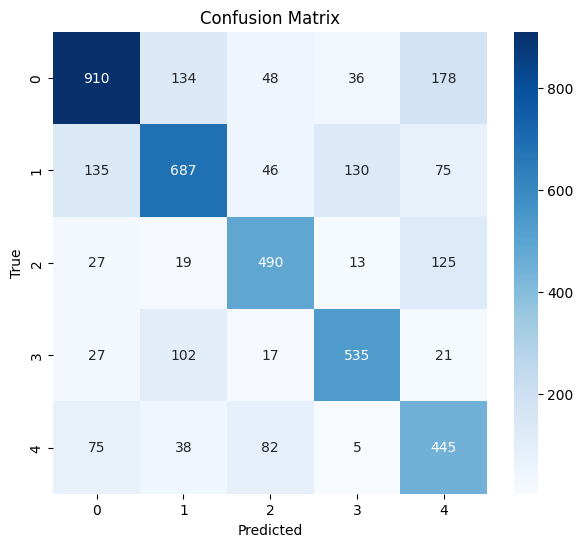

In [21]:


#--------------------resnet50--------------------


import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Collect predictions ----
all_preds = []
all_labels = []

resnet50.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = resnet50(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Metrics ----
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

print("Overall Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n Classification Report")
print(classification_report(all_labels, all_preds, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes)
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Overall Metrics
Accuracy : 0.6782
Precision: 0.6722
Recall   : 0.6995
F1-score : 0.6790

 Classification Report
              precision    recall  f1-score   support

           0     0.7680    0.6386    0.6973      1306
           1     0.6887    0.5545    0.6144      1073
           2     0.6498    0.8368    0.7315       674
           3     0.7017    0.7806    0.7390       702
           4     0.5531    0.6868    0.6127       645

    accuracy                         0.6782      4400
   macro avg     0.6722    0.6995    0.6790      4400
weighted avg     0.6884    0.6782    0.6766      4400



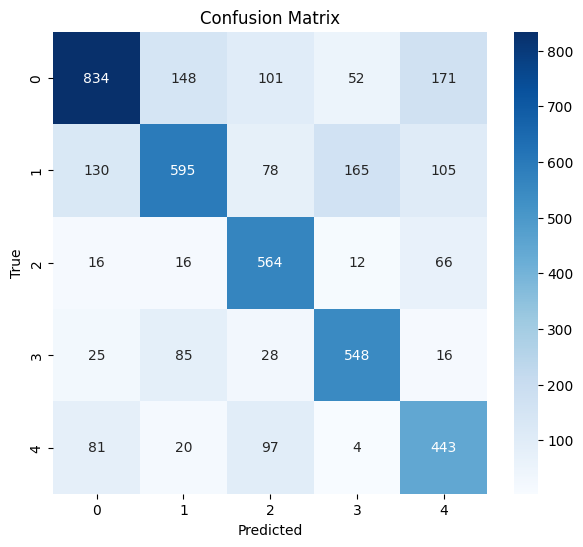

In [15]:

#--------------------vgg16--------------------



import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Collect predictions ----
all_preds = []
all_labels = []

vgg16.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = vgg16(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Metrics ----
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

print("Overall Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n Classification Report")
print(classification_report(all_labels, all_preds, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes)
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

Overall Metrics
Accuracy : 0.8245
Precision: 0.8210
Recall   : 0.8340
F1-score : 0.8265

 Classification Report
              precision    recall  f1-score   support

           0     0.8742    0.7979    0.8343      1306
           1     0.7930    0.7819    0.7874      1073
           2     0.8565    0.8680    0.8622       674
           3     0.8257    0.8974    0.8601       702
           4     0.7557    0.8248    0.7887       645

    accuracy                         0.8245      4400
   macro avg     0.8210    0.8340    0.8265      4400
weighted avg     0.8266    0.8245    0.8246      4400



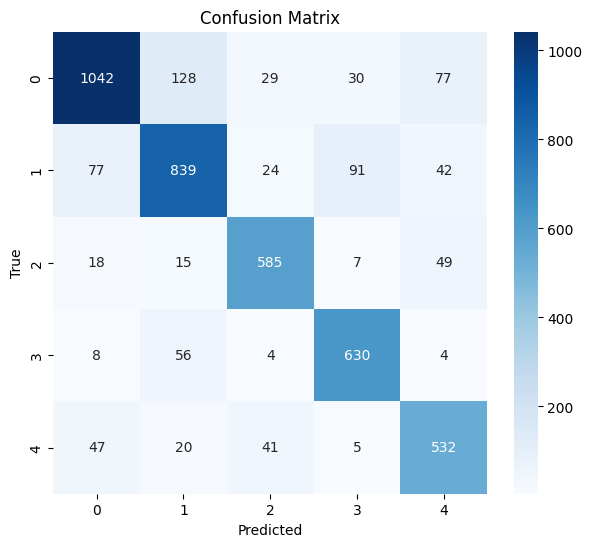

In [16]:

#--------------------efficientnet_b0--------------------



import numpy as np
from sklearn.metrics import (
    accuracy_score,
    precision_recall_fscore_support,
    confusion_matrix,
    classification_report
)
import matplotlib.pyplot as plt
import seaborn as sns

# ---- Collect predictions ----
all_preds = []
all_labels = []

efficientnet_b0.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = efficientnet_b0(images)
        preds = outputs.argmax(dim=1)

        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

# ---- Metrics ----
acc = accuracy_score(all_labels, all_preds)
precision, recall, f1, _ = precision_recall_fscore_support(
    all_labels, all_preds, average="macro"
)

print("Overall Metrics")
print(f"Accuracy : {acc:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall   : {recall:.4f}")
print(f"F1-score : {f1:.4f}")

print("\n Classification Report")
print(classification_report(all_labels, all_preds, digits=4))

# ---- Confusion Matrix ----
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(7, 6))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=range(num_classes),
    yticklabels=range(num_classes)
)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

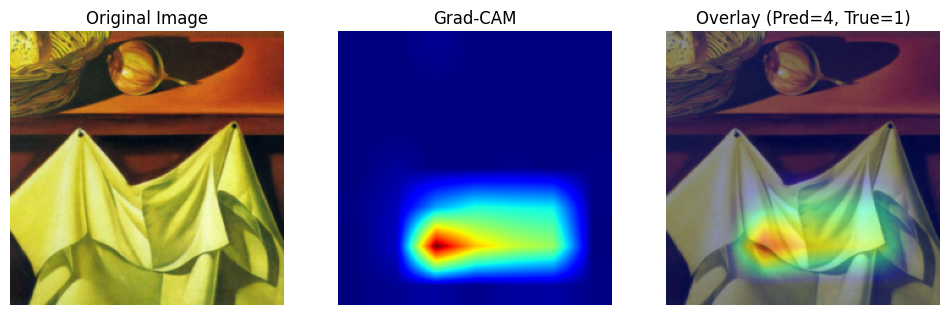

In [32]:

#--------------------resnet50--------------------




import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---- Grad-CAM Helper ----
class GradCAM:
    def __init__(self, resnet50, target_layer):
        self.resnet50 = resnet50
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.resnet50.zero_grad()
        output = self.resnet50(input_tensor)
        score = output[:, class_idx]
        score.backward()

        # Global average pooling on gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam


# ---- Get one test image ----
images, labels = next(iter(test_loader))
image = images[0:1].to(device)
true_label = labels[0].item()

# ---- Grad-CAM ----
target_layer = resnet50.layer4[-1]
gradcam = GradCAM(resnet50, target_layer)

pred_class = resnet50(image).argmax(dim=1).item()
cam = gradcam.generate(image, pred_class)

# ---- Resize CAM to image size ----
cam = cv2.resize(cam, (224, 224))

# ---- Prepare image ----
img = image[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

# ---- Heatmap & Overlay ----
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0
overlay = 0.6 * img + 0.4 * heatmap

overlay = np.clip(overlay, 0, 1)

# ---- Plot ----
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (Pred={pred_class}, True={true_label})")
plt.axis("off")

plt.show()

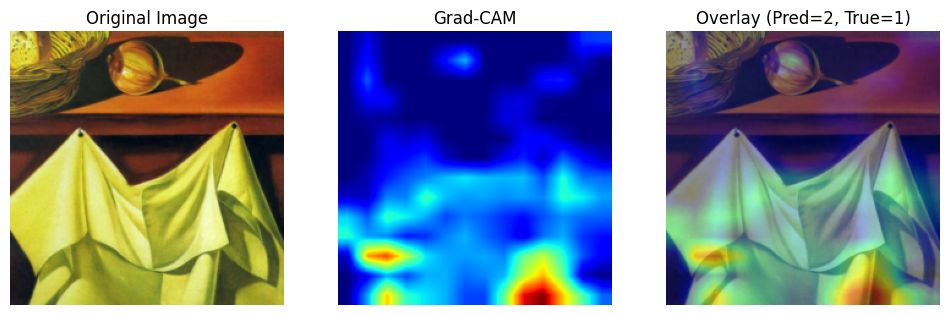

In [27]:

#--------------------vgg16--------------------



import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---- Grad-CAM Helper ----
class GradCAM:
    def __init__(self, vgg16, target_layer):
        self.vgg16 = vgg16
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.vgg16.zero_grad()
        output = self.vgg16(input_tensor)
        score = output[:, class_idx]
        score.backward()

        # Global average pooling on gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam


# ---- Get one test image ----
images, labels = next(iter(test_loader))
image = images[0:1].to(device)
true_label = labels[0].item()

# ---- Grad-CAM ----
target_layer = vgg16.features[-2] 
gradcam = GradCAM(vgg16, target_layer)

pred_class = vgg16(image).argmax(dim=1).item()
cam = gradcam.generate(image, pred_class)

# ---- Resize CAM to image size ----
cam = cv2.resize(cam, (224, 224))

# ---- Prepare image ----
img = image[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

# ---- Heatmap & Overlay ----
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.6 * img + 0.4 * heatmap

# ---- Plot ----
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (Pred={pred_class}, True={true_label})")
plt.axis("off")

plt.show()

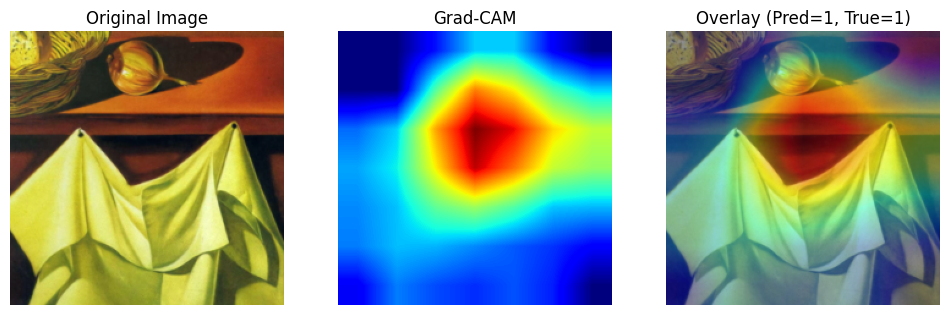

In [30]:

#--------------------efficientnet_b0--------------------



import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch

# ---- Grad-CAM Helper ----
class GradCAM:
    def __init__(self, efficientnet_b0, target_layer):
        self.efficientnet_b0 = efficientnet_b0
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output

        def backward_hook(module, grad_in, grad_out):
            self.gradients = grad_out[0]

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_backward_hook(backward_hook)

    def generate(self, input_tensor, class_idx):
        self.efficientnet_b0.zero_grad()
        output = self.efficientnet_b0(input_tensor)
        score = output[:, class_idx]
        score.backward()

        # Global average pooling on gradients
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam = (weights * self.activations).sum(dim=1)

        cam = torch.relu(cam)
        cam = cam.squeeze().detach().cpu().numpy()

        # Normalize
        cam = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam


# ---- Get one test image ----
images, labels = next(iter(test_loader))
image = images[0:1].to(device)
true_label = labels[0].item()

# ---- Grad-CAM ----
target_layer = efficientnet_b0.features[-2] 
gradcam = GradCAM(efficientnet_b0, target_layer)

pred_class = efficientnet_b0(image).argmax(dim=1).item()
cam = gradcam.generate(image, pred_class)

# ---- Resize CAM to image size ----
cam = cv2.resize(cam, (224, 224))

# ---- Prepare image ----
img = image[0].cpu().permute(1, 2, 0).numpy()
img = (img - img.min()) / (img.max() - img.min())

# ---- Heatmap & Overlay ----
heatmap = cv2.applyColorMap(np.uint8(255 * cam), cv2.COLORMAP_JET)
heatmap = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB) / 255.0

overlay = 0.6 * img + 0.4 * heatmap

# ---- Plot ----
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.imshow(img)
plt.title("Original Image")
plt.axis("off")

plt.subplot(1, 3, 2)
plt.imshow(cam, cmap="jet")
plt.title("Grad-CAM")
plt.axis("off")

plt.subplot(1, 3, 3)
plt.imshow(overlay)
plt.title(f"Overlay (Pred={pred_class}, True={true_label})")
plt.axis("off")

plt.show()

In [33]:

#--------------------RESNET50--------------------

import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Load image ----
img_path = "/kaggle/input/wikiart/Post_Impressionism/a.y.-jackson_barns-1926.jpg"
img_pil = Image.open(img_path).convert("RGB")
input_tensor = val_test_transform(img_pil).unsqueeze(0).to(device)

# ---- Load model (must match training) ----
num_classes = 5

# ---- Inference (Top-3) ----
with torch.no_grad():
    logits = resnet50(input_tensor)
    probs = torch.softmax(logits, dim=1)

topk_probs, topk_indices = torch.topk(probs, k=3)

print("Top-3 Predictions:")
for i in range(3):
    cls = selected_classes[topk_indices[0, i].item()]
    p = topk_probs[0, i].item() * 100
    print(f"{i+1}. {cls}: {p:.2f}%")

Top-3 Predictions:
1. Post_Impressionism: 79.05%
2. Expressionism: 13.91%
3. Impressionism: 2.69%


In [35]:

#--------------------efficientnet_b0--------------------


import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Load image ----
img_path = "/kaggle/input/wikiart/Post_Impressionism/a.y.-jackson_barns-1926.jpg"
img_pil = Image.open(img_path).convert("RGB")
input_tensor = val_test_transform(img_pil).unsqueeze(0).to(device)

# ---- Load model (must match training) ----
num_classes = 5

# ---- Inference (Top-3) ----
with torch.no_grad():
    logits = efficientnet_b0(input_tensor)
    probs = torch.softmax(logits, dim=1)

topk_probs, topk_indices = torch.topk(probs, k=3)

print("Top-3 Predictions:")
for i in range(3):
    cls = selected_classes[topk_indices[0, i].item()]
    p = topk_probs[0, i].item() * 100
    print(f"{i+1}. {cls}: {p:.2f}%")

Top-3 Predictions:
1. Post_Impressionism: 83.90%
2. Expressionism: 12.36%
3. Impressionism: 1.80%


In [36]:

#--------------------vgg16--------------------


import torch
import torch.nn as nn
from torchvision import models, transforms
from PIL import Image
import numpy as np
import cv2
import matplotlib.pyplot as plt

# ---- Load image ----
img_path = "/kaggle/input/wikiart/Post_Impressionism/a.y.-jackson_barns-1926.jpg"
img_pil = Image.open(img_path).convert("RGB")
input_tensor = val_test_transform(img_pil).unsqueeze(0).to(device)

# ---- Load model (must match training) ----
num_classes = 5

# ---- Inference (Top-3) ----
with torch.no_grad():
    logits = vgg16(input_tensor)
    probs = torch.softmax(logits, dim=1)

topk_probs, topk_indices = torch.topk(probs, k=3)

print("Top-3 Predictions:")
for i in range(3):
    cls = selected_classes[topk_indices[0, i].item()]
    p = topk_probs[0, i].item() * 100
    print(f"{i+1}. {cls}: {p:.2f}%")

Top-3 Predictions:
1. Post_Impressionism: 58.12%
2. Expressionism: 34.69%
3. Impressionism: 4.61%
